# Particle Filter / Monte Carlo Localization in 1D Motion Tracking


<img src="imgs/particle_filter.png" width="300" />
<img src="imgs/particle_filter2.png" width="300" />

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.animation as animation


motion model: pendulum


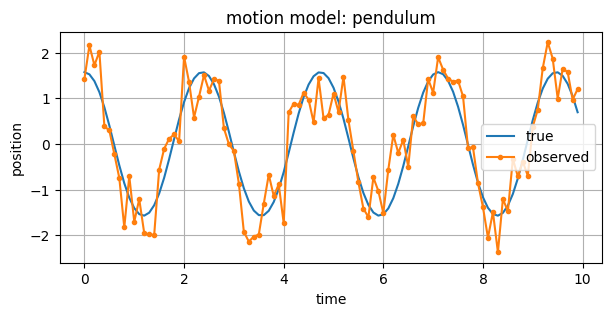

In [3]:
# select different motion
motion_select = 1
motion_types = ["sinusoidal", "pendulum", "respiratory"]
motion = motion_types[motion_select]
dt = 0.1
T = np.arange(0, 10, dt)

if motion == "sinusoidal":
    def f(x, dt):
        # parameters estimation
        # x[0] = A, x[1] = omega, x[2] = phi
        F = np.array([[1,0,0],
                      [0,1,0],
                      [0,0,x[1]*dt+x[2]]], dtype=np.float32)
        return F @ x
    
    def h(x):
        A = x[0]
        return A*np.sin(x[2])

    particle_range = np.array([[0, 2], [0, 10], [0, 2*np.pi]])
    zs = 1*np.sin(2*T+0.1)
    zs_ob = zs + np.random.normal(0, 0.2, len(T))
    print("motion model: sinusoidal")



elif motion == "pendulum":
    def f(x, dt, m=1, g=9.81, l=1):
        # motion model
        # x[0] = theta, x[1] = omega
        return np.array([x[1], -m*g*l*np.sin(x[0])])
    
    def h(x):
        return x[0]
    
    particle_range = np.array([[-np.pi, np.pi], [-10, 10]])
    ans = odeint(f, [np.pi/2, 0], t=T, args=(1,9.81,1))
    zs = ans[:,0]
    zs_ob = zs + np.random.normal(0, 0.5, len(T))
    print("motion model: pendulum")


elif motion == "respiratory":
    def f(x, dt):
        # respiratory motion model
        # A * np.cos(w * t + phi)**4
        # x[0] = A, x[1] = w, x[2] = phi
        F = np.array([[1,0,0],
                        [0,1,0],
                        [0,0,x[1]*dt+x[2]]],dtype=np.float32)
        return F @ x
    
    def h(x):
        A = x[0]
        return A * np.cos(x[2])**4
    
    particle_range = np.array([[0, 2], [0, 10], [0, 2*np.pi]])
    zs = 1 * np.cos(2*T+0.1)**4
    zs_ob = zs + np.random.normal(0, 0.2, len(T))
    print("motion model: respiratory")
else:
    print("motion not defined")

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(T, zs, label="true")
ax.plot(T, zs_ob,'.-', label="observed")
ax.legend()
ax.grid()
ax.set_xlabel("time")
ax.set_ylabel("position")
ax.set_title("motion model: {}".format(motion))
plt.show()

(3969, 2)


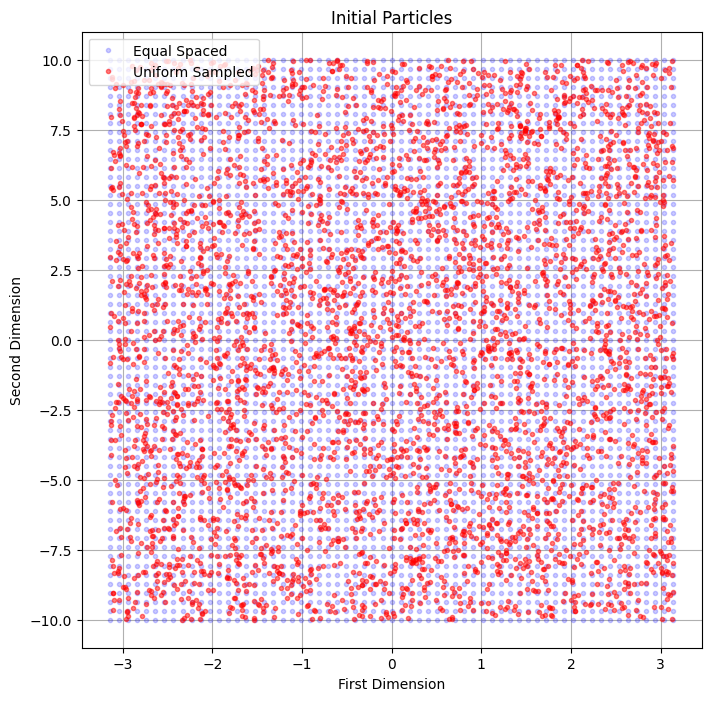

In [4]:
J = 4e3 # number of particles

class Particles:
    def __init__(self, n, particle_range: np.ndarray):
        ndim = particle_range.shape[0]
        n = int(n)
        self.xs = np.zeros((n, ndim))
        self.weights = None
        self.ndim = ndim
        self.n = n
        assert len(particle_range) == ndim, "particle_range must have the same dimension as the particles"
        self.particle_range = particle_range
        self.init_particles()

    def __iter__(self):
        return iter(self.xs)
    
    def __next__(self):
        return next(self.xs)
    
    def init_particles(self):
        """returns an array of particles"""
        for i in range(self.ndim):
            self.xs[:, i] = np.random.uniform(self.particle_range[i][0], self.particle_range[i][1], self.n)
        self.weights = np.ones(self.n) / self.n

    def equal_init_particles(self):
        n_sample = int(self.n ** (1 / self.ndim))
        xs = np.zeros((n_sample, self.ndim))
        for i in range(self.ndim):
            xs[:, i] = np.linspace(self.particle_range[i][0], self.particle_range[i][1], n_sample)
        new_x = np.meshgrid(*xs.T)
        new_x = np.array([x.flatten() for x in new_x]).T
        return new_x, np.ones(self.n) / self.n
    
    def normalize_weights(self):
        self.weights /= np.sum(self.weights)
    
    def resample(self):
        cumulative_sum = np.cumsum(self.weights)
        cumulative_sum[-1] = 1.
        indexes = np.searchsorted(cumulative_sum, np.random.uniform(0, 1, self.n))
        self.xs[:] = self.xs[indexes]

    def weighted_mean(self):
        return np.average(self.xs, weights=self.weights, axis=0)
    
    def mean(self):
        return np.mean(self.xs, axis=0)
        
particles = Particles(J, particle_range)
equal_particles, _ = particles.equal_init_particles()
print(equal_particles.shape)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(equal_particles[:,0], equal_particles[:,1], 'b.', alpha=0.2, label='Equal Spaced')
ax.plot([xs[0] for xs in particles], [xs[1] for xs in particles], 'r.', alpha=0.5, label='Uniform Sampled')
ax.set_xlabel('First Dimension')
ax.set_ylabel('Second Dimension')
ax.set_title('Initial Particles')
ax.grid(True, which='both')
ax.legend(loc='upper left')
plt.show()

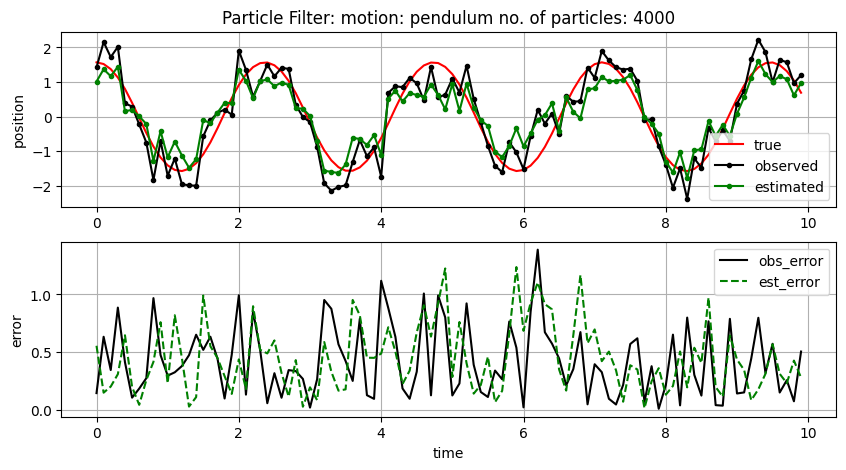

In [5]:
if motion == "sinusoidal":
    R = 0.1
    Q = 0.1
elif motion =="pendulum":
    R = 7
    Q = 5
elif motion ==  "respiratory":
    R = 0.1
    Q = 0.1
else:
    raise NotImplementedError
    
def gaussian_pdf(x, mu, sigma):
    """returns the probability of x for 1-dim Gaussian with mean mu and var. sigma"""
    return (
        1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5 * (x - mu) ** 2 / sigma**2)
    )

def save_particles_to_fig(particles, index):
    """save particles to figure"""
    ndim = particles.ndim
    fig, ax = plt.subplots(ndim+1, 1, figsize=(10, 5))
    ax[0].plot(particles.weights,'.-')
    for i in range(ndim):
        ax[i+1].plot(particles.xs[:, i],'.-')
    # plt.show(block=False)
    fig.savefig(f"particles_imgs/particles{index}.png")
    plt.close(fig)


zs_est = []
particles = Particles(J, particle_range)
for i, t in enumerate(T):
    # save_particles_to_fig(particles, i)
    # predict
    for pi, xs in enumerate(particles):
        xs = f(xs, dt) + np.random.randn(*xs.shape) * np.sqrt(Q)
        particles.xs[pi] = xs 
        particles.weights[pi] = gaussian_pdf(zs_ob[i],h(xs),R)
    particles.normalize_weights()
    # correct
    particles.resample()
    zs_est.append(h(particles.mean()))

# plot
fig, ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(T, zs, "r", label="true")
ax[0].plot(T, zs_ob, "k.-", label="observed")
ax[0].plot(T, zs_est, "g.-", label="estimated")
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel("position")
ax[1].plot(T, np.abs(zs_ob - zs), "k", label="obs_error")
ax[1].plot(T, np.abs(zs_est - zs), "g--", label="est_error")
# ax[1].plot(T, np.abs(np.abs(zs_est - zs) - np.abs(zs_ob - zs)), "r", label="error_diff")
ax[1].legend()
ax[1].set_xlabel("time")
ax[1].set_ylabel("error")
ax[1].grid()
ax[0].set_title(f"Particle Filter: motion: {motion} no. of particles: {int(J)}")
plt.show()

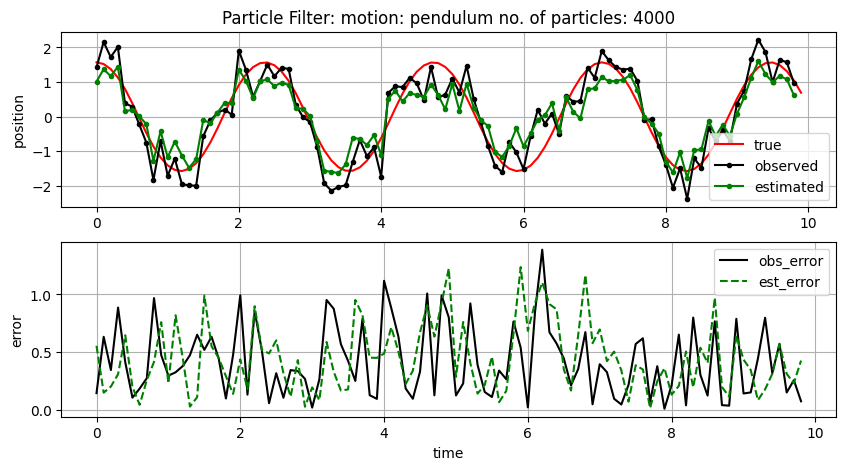

In [6]:
fig, ax = plt.subplots(2,1,figsize=(10,5))
obs_err = np.abs(zs_ob - zs)
est_err = np.abs(zs_est - zs)
err_diff = np.abs(obs_err - est_err)
def update(i):
    ax[0].clear()
    ax[0].plot(T, zs, "r", label="true")
    ax[0].plot(T[:i], zs_ob[:i], "k.-", label="observed")
    ax[0].plot(T[:i], zs_est[:i], "g.-", label="estimated")
    ax[0].legend()
    ax[0].grid()
    ax[0].set_ylabel("position")
    ax[1].clear()
    ax[1].plot(T[:i], obs_err[:i], "k", label="obs_error")
    ax[1].plot(T[:i], est_err[:i], "g--", label="est_error")
    # ax[1].plot(T[:i], err_diff[:i], "r", label="error_diff")
    ax[1].legend()
    ax[1].set_xlabel("time")
    ax[1].set_ylabel("error")
    ax[1].grid()
    ax[0].set_title(f"Particle Filter: motion: {motion} no. of particles: {int(J)}")
    
ani = animation.FuncAnimation(fig, update, frames=len(T), interval=200)
ani.save('PF_estimation.gif', writer='imagemagick')
plt.show()